# FLIR Thermal Tools
This demo script demonstrates the work order and functions available as part of this reposititory. Some of the functionality includes:
  * Extracting RGB image associated with FLIR temperature image
  * Co-Registering the RGB with temperature image
  * Classifying the RGB image so that it can be used to grab pixels of interest from the temperature image. 
  
Note: RGB mean Red/Green/Blue image or True Color or what we would see with our eyes.

In [1]:
# Importing Functions
import numpy as np
import matplotlib.pyplot as plt
import flirimageextractor
import utilities as u
import matplotlib
matplotlib.use('agg') # the backend will change in the code to allow GUI on jupyter notebook

## Set Directory Locations

In [2]:
# Set the directory of the FLIR images
dirLoc = 'C:/Users/susanmeerdink/Documents/Git/FLIR_thermal_tools/Test_Images/' # Danforth: /home/smeerdink/Code/FLIR_thermal_tools/Test_Images/

# The path to the perl exiftool package may need change depending on where it is installed.
exiftoolpath = "C:\\Users\\susanmeerdink\\.utilities\\exiftool.exe"  # Danforth: /usr/local/bin/exiftool.exe

## Load FLIR Image using flirimageextractor

In [3]:
filename = dirLoc + 'IR_56020.jpg'
flir = flirimageextractor.FlirImageExtractor(exiftool_path=exiftoolpath)
flir.process_image(filename, RGB=True)

## Extract and examine temperature and full resolution RGB images
Most FLIR cameras take a temperature image and a corresponding RGB image. 
The RGB camera is higher resolution and has a larger field of view, so it does not directly match the temperature image. 

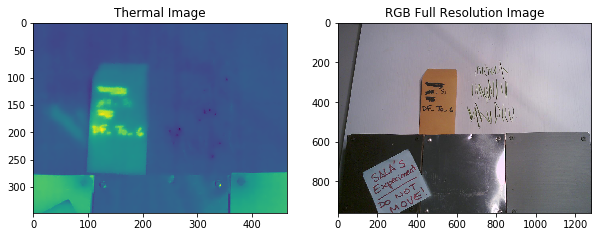

In [4]:
# Get the data from the FLIR image
therm = flir.get_thermal_np() # Get the temperature data
rgb_fullres = flir.get_rgb_np() # Get the Red/Green/Blue image data

# Plot the data from the FLIR Image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(therm)
plt.title('Thermal Image')
plt.subplot(1,2,2)
plt.imshow(rgb_fullres)
plt.title('RGB Full Resolution Image')
plt.show() # Depending on python platform you may need to use block='TRUE' 

## Check temperature and RGB image registration 
FLIR cameras have two lens: 1) thermal lens 2) RGB lens. These lenses are physically offset from each other and require an adjustment to align the images. This can be changed in camera settings, but can also be done manually afterwards. Below are the temperature and RGB images using the offset provided in FLIR file header.

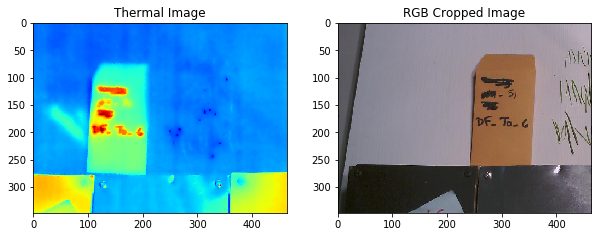

In [5]:
rgb_lowres, rgb_crop = u.extract_coarse_image(flir)

## Determine manual correction of temperature and RGB registration 
Based on the images above, the registration between the temperature and RGB images are not correct. In the next step, the user will click on points that correspond to the same location in the temperature and RGB images. These points will be used to figure out the x and y pixel offset.

In [21]:
# Changing Matplotlib backend to support GUI interaction
# Without this only the figure will appear, but the user will not be able to provide points.
matplotlib.use('TkAgg')

offset, pts_temp, pts_rgb = u.manual_img_registration(flir)
print('X pixel offset is ' + str(offset[0]) + ' and Y pixel offset is ' + str(offset[1]))

X pixel offset is -155.0 and Y pixel offset is -69.0


### How-To for manual image registration
It depends on the matplotlib built in buttons: https://matplotlib.org/3.1.1/users/navigation_toolbar.html. I suggest selecting at a minimum three tie point locations. The average x and y offset will be calculated from these points.   
Important things to note:
  * You MUST select the thermal point first THEN the RGB point.
  * ANY TIME you click (even with zoom and pan) you add a point. Make sure to right click after zooming or panning to remove that point. 
  * The back arrow is nice to get back to the full screen image, then you don't risk accident points using pan feature.

## Fix Temperature and RGB image registration with manual correction
With the manually determined offsets, the temperature and RGB images are now aligned. This allows us to classify the RGB image and determine the groups of material types in the image. This information can be used to correct the temperature data for the correct emissivity OR pull out a particular group of interest.

NOTE: Sometimes I get an extra image that I can manuever around, but not click. Close that image and the image registration image should be the next image.

C:\Users\susanmeerdink\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


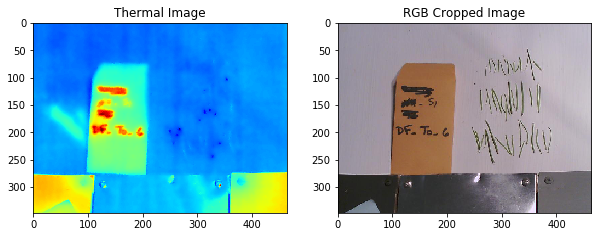

In [8]:
matplotlib.use('agg')  # Change backend back to default non-gui backend

offset = [-155, -70]  # This is the manual offset I got when running the demo images.
rgb_lowres, rgb_crop = u.extract_coarse_image(flir, offset=offset, plot=1)

##  Build a mask of your area of interest 
In this example, we are interested in pulling out the plant material pixels. In order to improve performance of K-Means classification, mask out pixels that are NOT of interest. 

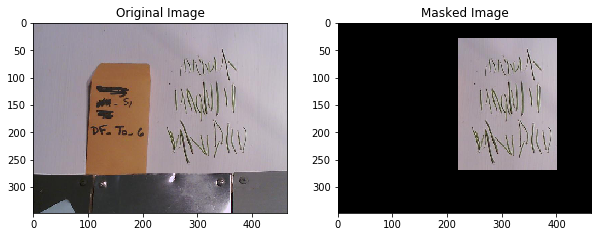

In [9]:
mask = np.zeros((rgb_crop.shape[0], rgb_crop.shape[1]))
mask[30:270,220:400] = 1
rgb_mask = u.apply_mask_to_rgb(mask, rgb_crop)

## Classify using K-Means the newly masked rgb image

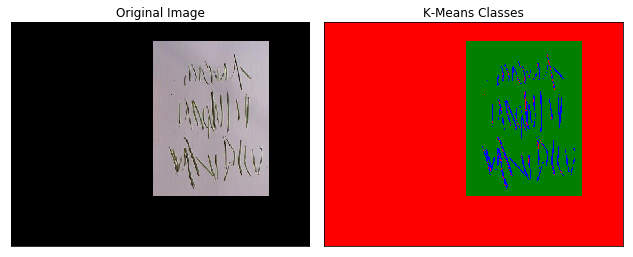

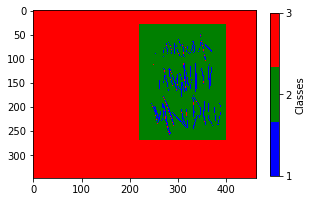

In [10]:
rgb_class, rgb_qcolor = u.classify_rgb(rgb_mask, 3)

## Pull out just the class for plant material

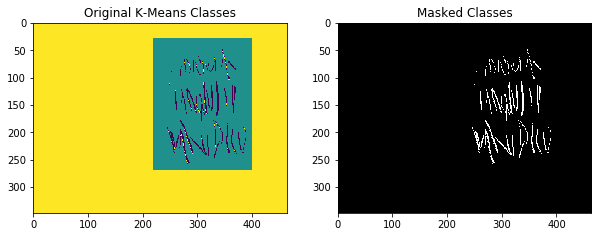

In [16]:
class_mask = u.create_class_mask(rgb_class, 1)

## Correct temperature imagery for correct emissivity
The FLIR thermal camera has an assume emissivity of 0.95 (this can be changed in the settings), but many materials do not have an emissivity of 0.95. Due to the relationship between emissivity and temperature, the temperature retrieved by the FLIR camera will not be the same for materials with different emissivity. The following function takes in the user provided emissivities for each K-Means class and corrects the temperature data.

Input the emissivity for each class. If unknown put 0.95
Emissivity for Class 1: 0.98
Emissivity for Class 2: 0.95
Emissivity for Class 3: 0.95


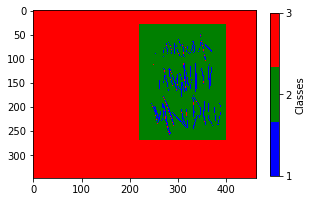

In [17]:
emiss_img = u.develop_correct_emissivity(rgb_class)

## Pull out thermal pixels of just plants for single image

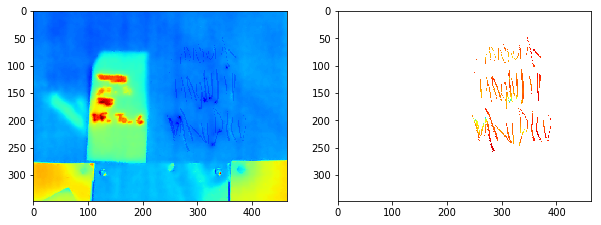

In [18]:
temp_mask = u.extract_temp_for_class(flir, class_mask, emiss_img)

# Pull out thermal pixels of just plants for a set of images

Found 3 files.


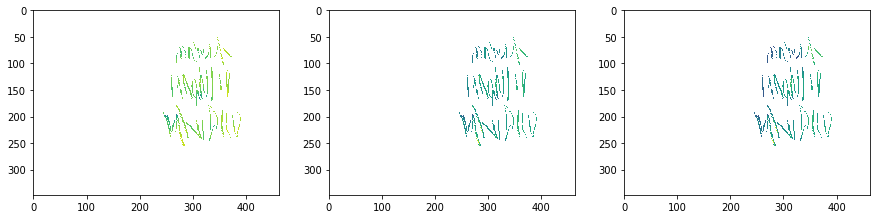

In [19]:
all_temp_mask = u.batch_extract_temp_for_class(dirLoc, class_mask, emiss_img, exiftoolpath=exiftoolpath)

# Plot Results from the Three Test Images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(all_temp_mask[:,:,0])
plt.subplot(1,3,2)
plt.imshow(all_temp_mask[:,:,1])
plt.subplot(1,3,3)
plt.imshow(all_temp_mask[:,:,2])
plt.show() # Depending on python platform you may need to use block='TRUE' 

## Plot temperature timeseries of just plant materials

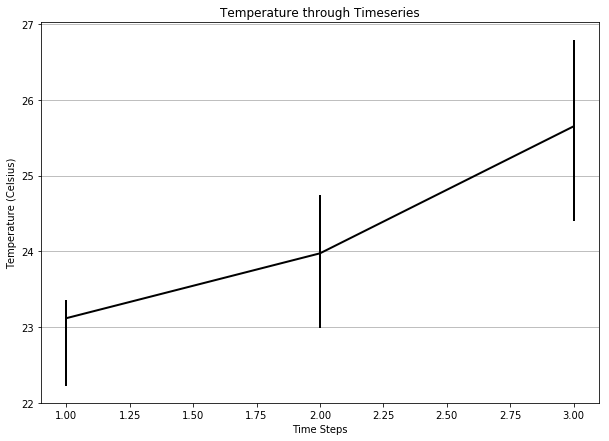

In [20]:
u.plot_temp_timeseries(all_temp_mask)